In [59]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# ETAPE 1

##### augmentation de données

In [11]:
# 1. Charger les données
df = pd.read_csv('categories.csv')

In [13]:
df.head()

,image_name,category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,"[""Home Furnishing"
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,"[""Baby Care"
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,"[""Baby Care"
3,d4684dcdc759dd9cdf41504698d737d8.jpg,"[""Home Furnishing"
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,"[""Home Furnishing"


In [24]:
# Ajouter le chemin complet aux images
df["image_path"] = df["image_name"].apply(lambda x: os.path.join("Images", x))

In [28]:
df.head()

,image_name,category,image_path
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,"[""Home Furnishing",Images\55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,"[""Baby Care",Images\7b72c92c2f6c40268628ec5f14c6d590.jpg
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,"[""Baby Care",Images\64d5d4a258243731dc7bbb1eef49ad74.jpg
3,d4684dcdc759dd9cdf41504698d737d8.jpg,"[""Home Furnishing",Images\d4684dcdc759dd9cdf41504698d737d8.jpg
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,"[""Home Furnishing",Images\6325b6870c54cd47be6ebfbffa620ec7.jpg


In [32]:
# Séparer le dataset en Train (70%), Validation (15%) et Test (15%)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df["category"])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["category"])

# Vérifier la répartition
print(f"Train: {len(train_df)} images, Validation: {len(val_df)} images, Test: {len(test_df)} images")

Train: 735 images, Validation: 157 images, Test: 158 images


##### Créer le modele

In [34]:
batch_size = 32  # Nombre d'images par batch

# Fonction pour créer un data generator
def data_flow_fct(data, datagen, data_type=None):
    return datagen.flow_from_dataframe(
        dataframe=data,
        x_col="image_path", 
        y_col="category",  
        target_size=(224, 224),  
        class_mode="categorical", 
        batch_size=batch_size,
        shuffle=True,  
        seed=42,
        subset=data_type 
    )

# Data Augmentation pour l'entraînement
datagen_train = ImageDataGenerator(
    rescale=1./255,  # Normalisation des pixels entre 0 et 1
    rotation_range=20,  # Rotation aléatoire
    width_shift_range=0.2,  # Décalage horizontal
    height_shift_range=0.2,  # Décalage vertical
    shear_range=0.2,  # Transformation affine
    zoom_range=0.2,  # Zoom aléatoire
    horizontal_flip=True,  # Miroir horizontal
    fill_mode="nearest",  # Remplissage des pixels
    validation_split=0.25  # 25% des images seront utilisées pour la validation
)

# Générer les images pour l'entraînement et la validation
train_flow = data_flow_fct(train_df, datagen_train, data_type="training")
val_flow = data_flow_fct(val_df, datagen_train, data_type="validation")

# Générer les images pour le test (sans augmentation)
datagen_test = ImageDataGenerator(rescale=1./255)  # Juste la normalisation
test_flow = data_flow_fct(test_df, datagen_test, data_type=None)


Found 552 validated image filenames belonging to 7 classes.
Found 39 validated image filenames belonging to 7 classes.
Found 158 validated image filenames belonging to 7 classes.


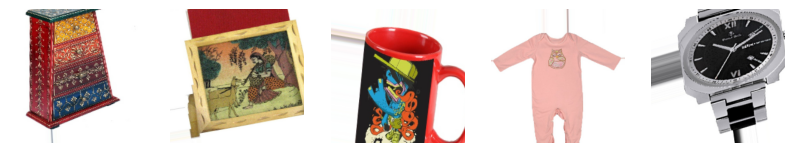

In [39]:
# Extraire un batch d'images augmentées
x_batch, y_batch = next(train_flow)

# Afficher les premières images transformées
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_batch[i])  # Affichage des images augmentées
    plt.axis("off")
plt.show()

In [43]:
# Charger le modèle VGG16 pré-entraîné sans la dernière couche fully connected
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

#Débloquer les dernières couches de VGG16
for layer in base_model.layers[-4:]:  # Débloquer 4 dernières couches
    layer.trainable = True

# Ajouter de nouvelles couches adaptées à mon dataset (7 classes)
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Transforme la sortie de VGG16 en un vecteur de taille fixe
x = Dense(256, activation="relu")(x)  # Couche dense de 256 neurones
x = Dropout(0.5)(x)  # Dropout pour éviter l'overfitting
x = Dense(128, activation="relu")(x)  # Autre couche dense
x = Dropout(0.5)(x)  # Dropout supplémentaire
output_layer = Dense(7, activation="softmax")(x) 

# Création du nouveau modèle
model = Model(inputs=base_model.input, outputs=output_layer)

# Compilation du modèle
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Réduire le learning rate
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Vérifier que le modèle est bien mis à jour
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,3

 Total params: 14,879,815 (56.76 MB)

 Trainable params: 14,879,815 (56.76 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Création du callback ModelCheckpoint
checkpoint = ModelCheckpoint(
    "best_model.h5",  # Sauvegarde du meilleur modèle
    monitor="val_loss",  # Surveiller la perte sur validation
    save_best_only=True,  # Sauvegarde uniquement le meilleur modèle
    mode="min",  # On cherche à minimiser la val_loss
    verbose=1
)

# Ensuite, relancer l'entraînement avec ce callback
history = model.fit(
    train_flow,
    validation_data=val_flow,
    epochs=100,
    callbacks=[checkpoint],  
    verbose=1
)

In [49]:
# Charger le modèle sauvegardé
model = load_model("best_model.h5")

# Vérifier que le modèle est bien chargé
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,3

 Total params: 14,879,817 (56.76 MB)

 Trainable params: 14,879,815 (56.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [51]:
# Évaluation du modèle sur les données de test
test_loss, test_accuracy = model.evaluate(test_flow)

print(f" Performance sur le Test Set :")
print(f" Test Accuracy : {test_accuracy * 100:.2f}%")
print(f" Test Loss : {test_loss:.4f}")

C:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.7112 - loss: 1.1947
 Performance sur le Test Set :
 Test Accuracy : 74.68%
 Test Loss : 1.0212


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


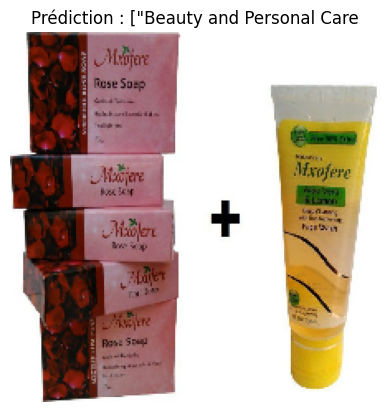

In [61]:
# Sélectionner une image de test
img_path = "Images/00d84a518e0550612fcfcba3b02b6255.jpg"  # Remplace par une image de ton dataset

def test_model(img_path) :
    # Charger et prétraiter l’image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Ajouter une dimension batch
    img_array /= 255.0  # Normalisation
    
    # Faire la prédiction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    
    # Afficher l’image avec la prédiction
    plt.imshow(img)
    plt.title(f"Prédiction : {list(test_flow.class_indices.keys())[predicted_class]}")
    plt.axis("off")
    plt.show()
test_model(img_path) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


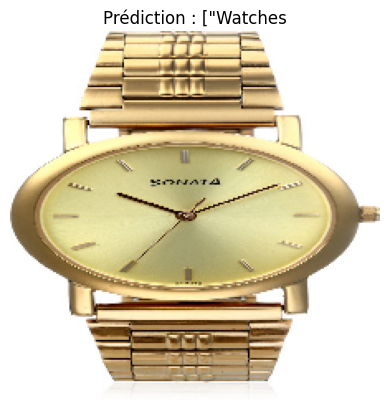

In [63]:
test_model("Images/1fcff864d6e397e1424d5366e6c6b8fa.jpg" ) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


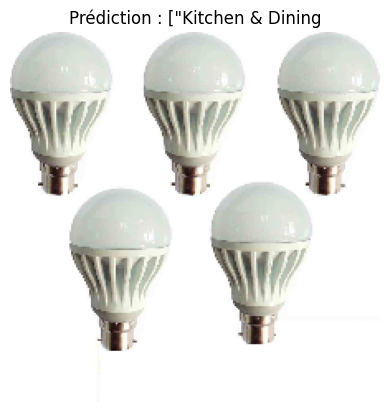

In [64]:
test_model("Images/0ca8e323551dd7107ef57ef7c3e77aee.jpg" ) 